# Data preprocessing

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn import tree
import xgboost as xgb #pip3 install xgboost
import pickle
from sklearn.tree import plot_tree
from xgboost import plot_tree
from sklearn.tree import export_graphviz
from xgboost import plot_importance
from category_encoders import TargetEncoder #for target (mean) encoding
import category_encoders
import dash
from dash import dcc, html
import plotly.express as px
from dash.dependencies import Input, Output
import warnings

#Turing off the warnings
warnings.filterwarnings('ignore')

##Load data
data_prague = pd.read_csv('listings.csv')
data_prague
 
##Exploratory Data Analysis
data_prague.head
data_prague.describe

print("Rows count: ", data_prague.shape[0])
print("Columns count: ", data_prague.shape[1])
rows_count_1 =  data_prague.shape[0]
columns_count_1 = data_prague.shape[1]

Rows count:  9388
Columns count:  75


Original dataset contains 74 variables and 9388 observations. 

We can also see number of observation for each variable and type. 

In [39]:
##Data preprocessing
data_prague.info()
 
### Show the number of NA variables in dataset
isna = data_prague.isna().sum()
isnadf = pd.DataFrame({"isna": isna})
isnadf
 
######## Treating of features with all values being NA
#Remove the column which has all values as NaN - in total 6 columns.
data_prague.dropna(axis = 1, how = 'all', inplace = True)
data_prague.shape
columns_count_2 = data_prague.shape[1]
print("Number of removed columns: ", (columns_count_1 - columns_count_2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9388 entries, 0 to 9387
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            9388 non-null   int64  
 1   listing_url                                   9388 non-null   object 
 2   scrape_id                                     9388 non-null   int64  
 3   last_scraped                                  9388 non-null   object 
 4   source                                        9388 non-null   object 
 5   name                                          9388 non-null   object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         4936 non-null   object 
 8   picture_url                                   9388 non-null   object 
 9   host_id                                       9388 non-null   i

Here we want to determine if we need to use all the features regarding reviews -
whether we want to keep reviews of specific categories. For that purpose we used 
correlation matrix to determine correlation within variables. 

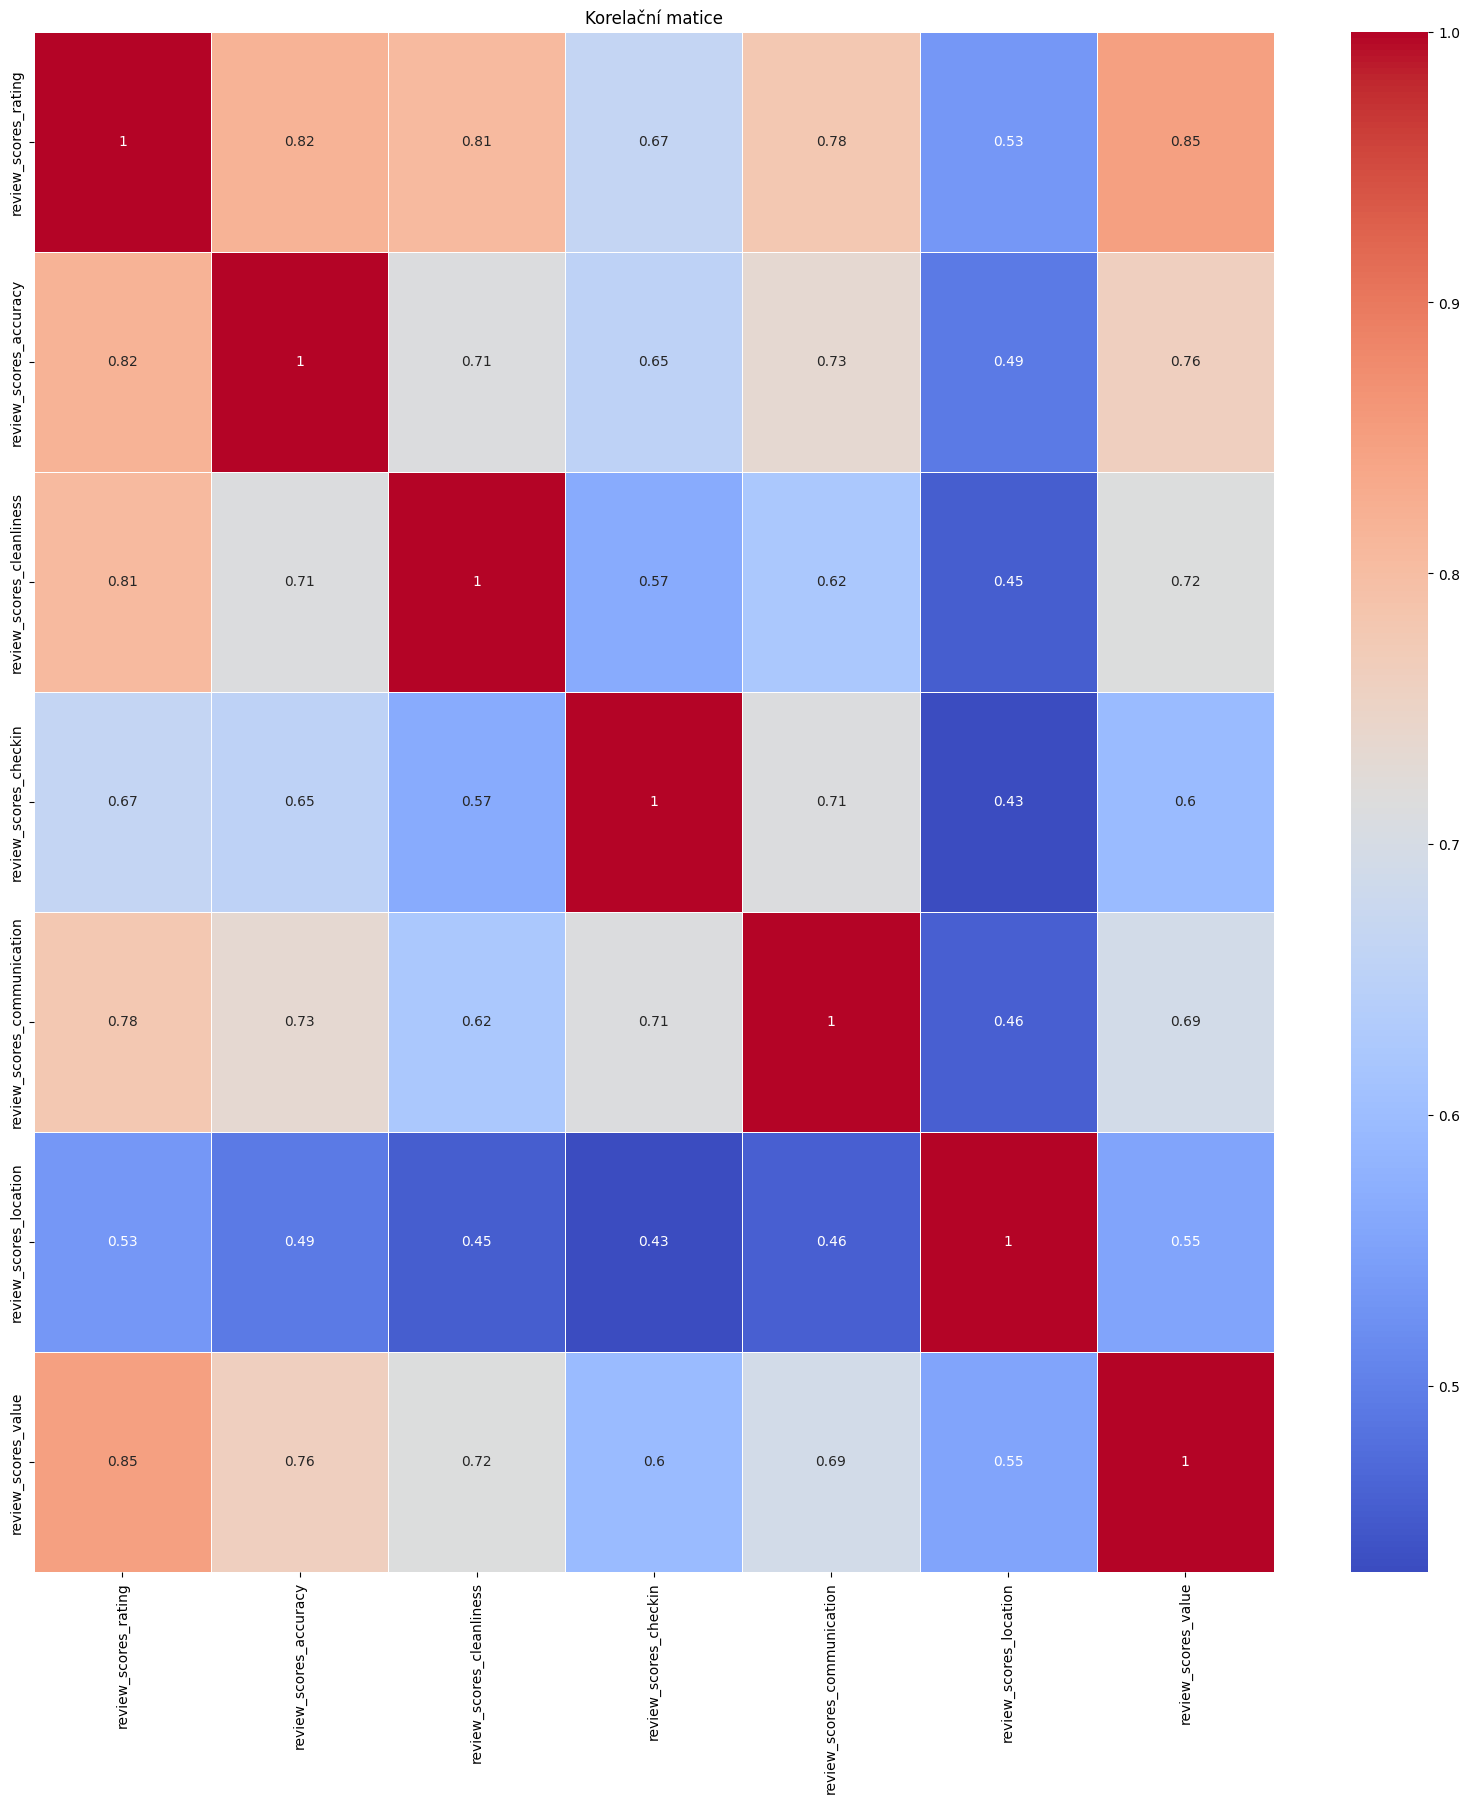

In [40]:
correlation_matrix = data_prague[['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']].corr()

#visualization of the correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Korelační matice')
plt.show()

In [41]:
#Drop certain variables that are not important for models.

columns_to_drop = ['listing_url',
                  'scrape_id',
                  'last_scraped',
                  'source',
                  'picture_url',
                  'host_url',
                  'host_name',
                  'host_thumbnail_url',
                  'host_picture_url',
                  'host_verifications',
                  'neighbourhood', # we keep the cleansed one, drop this one
                  'amenities',
                  'calendar_last_scraped',
                  'first_review',
                  'last_review',
                  'host_neighbourhood']
 
data_prague.drop(columns_to_drop, axis=1, inplace=True)
 
data_prague.info()
data_prague.describe


#Deleted observation with zero values of price. 
data_prague_price = data_prague.dropna(subset=['price'])
isna_price = data_prague_price.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9388 entries, 0 to 9387
Data columns (total 53 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            9388 non-null   int64  
 1   name                                          9388 non-null   object 
 2   neighborhood_overview                         4936 non-null   object 
 3   host_id                                       9388 non-null   int64  
 4   host_since                                    9388 non-null   object 
 5   host_location                                 7197 non-null   object 
 6   host_about                                    5407 non-null   object 
 7   host_response_time                            8207 non-null   object 
 8   host_response_rate                            8207 non-null   object 
 9   host_acceptance_rate                          8682 non-null   o

Editting variables

In [42]:
#variable edit - neighborhood_overview create dummy variable if empty zero, text 1
data_prague_price['neighborhood_overview'] = data_prague_price['neighborhood_overview'].apply(lambda x: 0 if pd.isna(x) else 1)
data_prague_price['neighborhood_overview'].unique() #check
 
#variable edit - neighborhood_overview create dummy variable if empty zero, text 1
data_prague_price['host_about'] = data_prague_price['host_about'].apply(lambda x: 0 if pd.isna(x) else 1)
data_prague_price['host_about'].unique() #check
 
#variable edit - host_location create dummy variable if empty zero, text 1
data_prague_price['host_location'] = data_prague_price['host_location'].apply(lambda x: 1 if pd.notna(x) and 'Czechia' in x else 0)
data_prague_price['host_location'].unique() #check
data_prague_price['host_location'].sum() #check

#variable edit - creating dummy from room type
# reference category is entire home
df_dummy=pd.get_dummies(data = data_prague_price["room_type"], drop_first = True)
df_dummy
data_prague_price = pd.concat([data_prague_price, df_dummy], axis=1)
data_prague_price.dtypes

id                                                int64
name                                             object
neighborhood_overview                             int64
host_id                                           int64
host_since                                       object
host_location                                     int64
host_about                                        int64
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                                object
host_listings_count                               int64
host_total_listings_count                         int64
host_has_profile_pic                             object
host_identity_verified                           object
neighbourhood_cleansed                           object
latitude                                        float64
longitude                                       

lets take a look at variable host_since

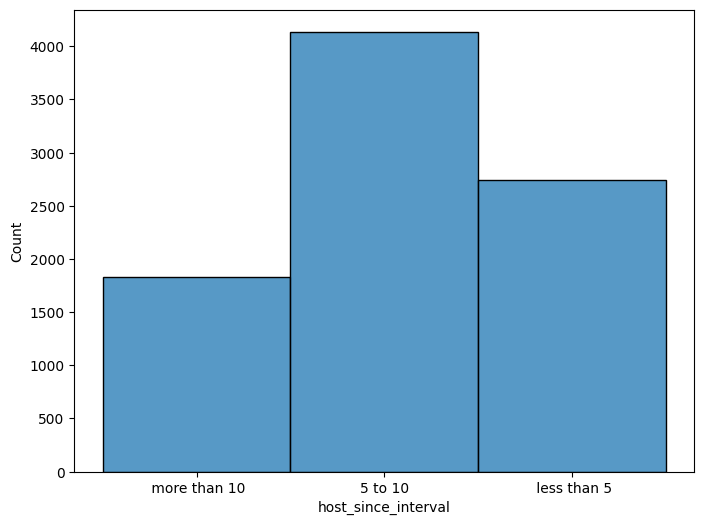

In [43]:
data_prague_price['host_since'] = pd.to_datetime(data_prague_price['host_since'])

date_range = pd.date_range(start=min(data_prague_price['host_since']), end=max(data_prague_price['host_since']), freq='D')
data_prague_price['host_since_interval'] = pd.cut(data_prague_price['host_since'], bins=3, labels=[' more than 10', '5 to 10', ' less than 5'], right=True)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(data_prague_price["host_since_interval"])
plt.show()

# decided to make categories 
# The reference category is more than 10 years on airbnb 
df_dummy = pd.get_dummies(data=data_prague_price["host_since_interval"], drop_first=True)
df_dummy
data_prague_price = pd.concat([data_prague_price, df_dummy], axis=1)
data_prague_price.dtypes


#variable edit - price to float type
data_prague_price['price'] = data_prague_price['price'].str.replace('$','').str.replace(',','')
data_prague_price['price'] = data_prague_price['price'].astype(float)
data_prague_price.dtypes

# Converting variables with % to numbers
data_prague_price['host_acceptance_rate'] = data_prague_price['host_acceptance_rate'].str.rstrip('%').apply(pd.to_numeric, errors='ignore')
data_prague_price['host_response_rate'] = data_prague_price['host_response_rate'].str.rstrip('%').apply(pd.to_numeric, errors='ignore')


#Using the logarithm of prices helps normalize skewed distributions, 
#making data more symmetric and easier to interpret statistically. 
data_prague_price['Lprice'] = np.log(data_prague_price['price'])
 
data_prague_price['bathrooms_cislo'] = data_prague_price['bathrooms_text']
 
data_prague_price['bathrooms_cislo'] = data_prague_price['bathrooms_cislo'].str.replace('Half-bath','0.5').str.replace('Shared half-bath','0.5').str.replace('Private half-bath','0.5')
data_prague_price['bathrooms_cislo'] = data_prague_price['bathrooms_cislo'].str.extract(r'(\d+\.?\d*)').astype(float)#nechá pouze čísla

data_prague_price['bathrooms_text'] = data_prague_price['bathrooms_text'].apply(lambda x: re.sub(r'\d', '', str(x)))
data_prague_price['bathrooms_text'] = data_prague_price['bathrooms_text'].str.replace('.','')



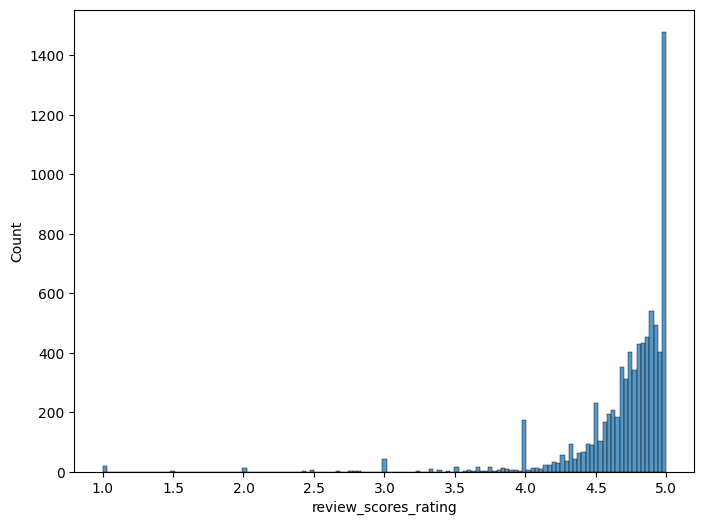

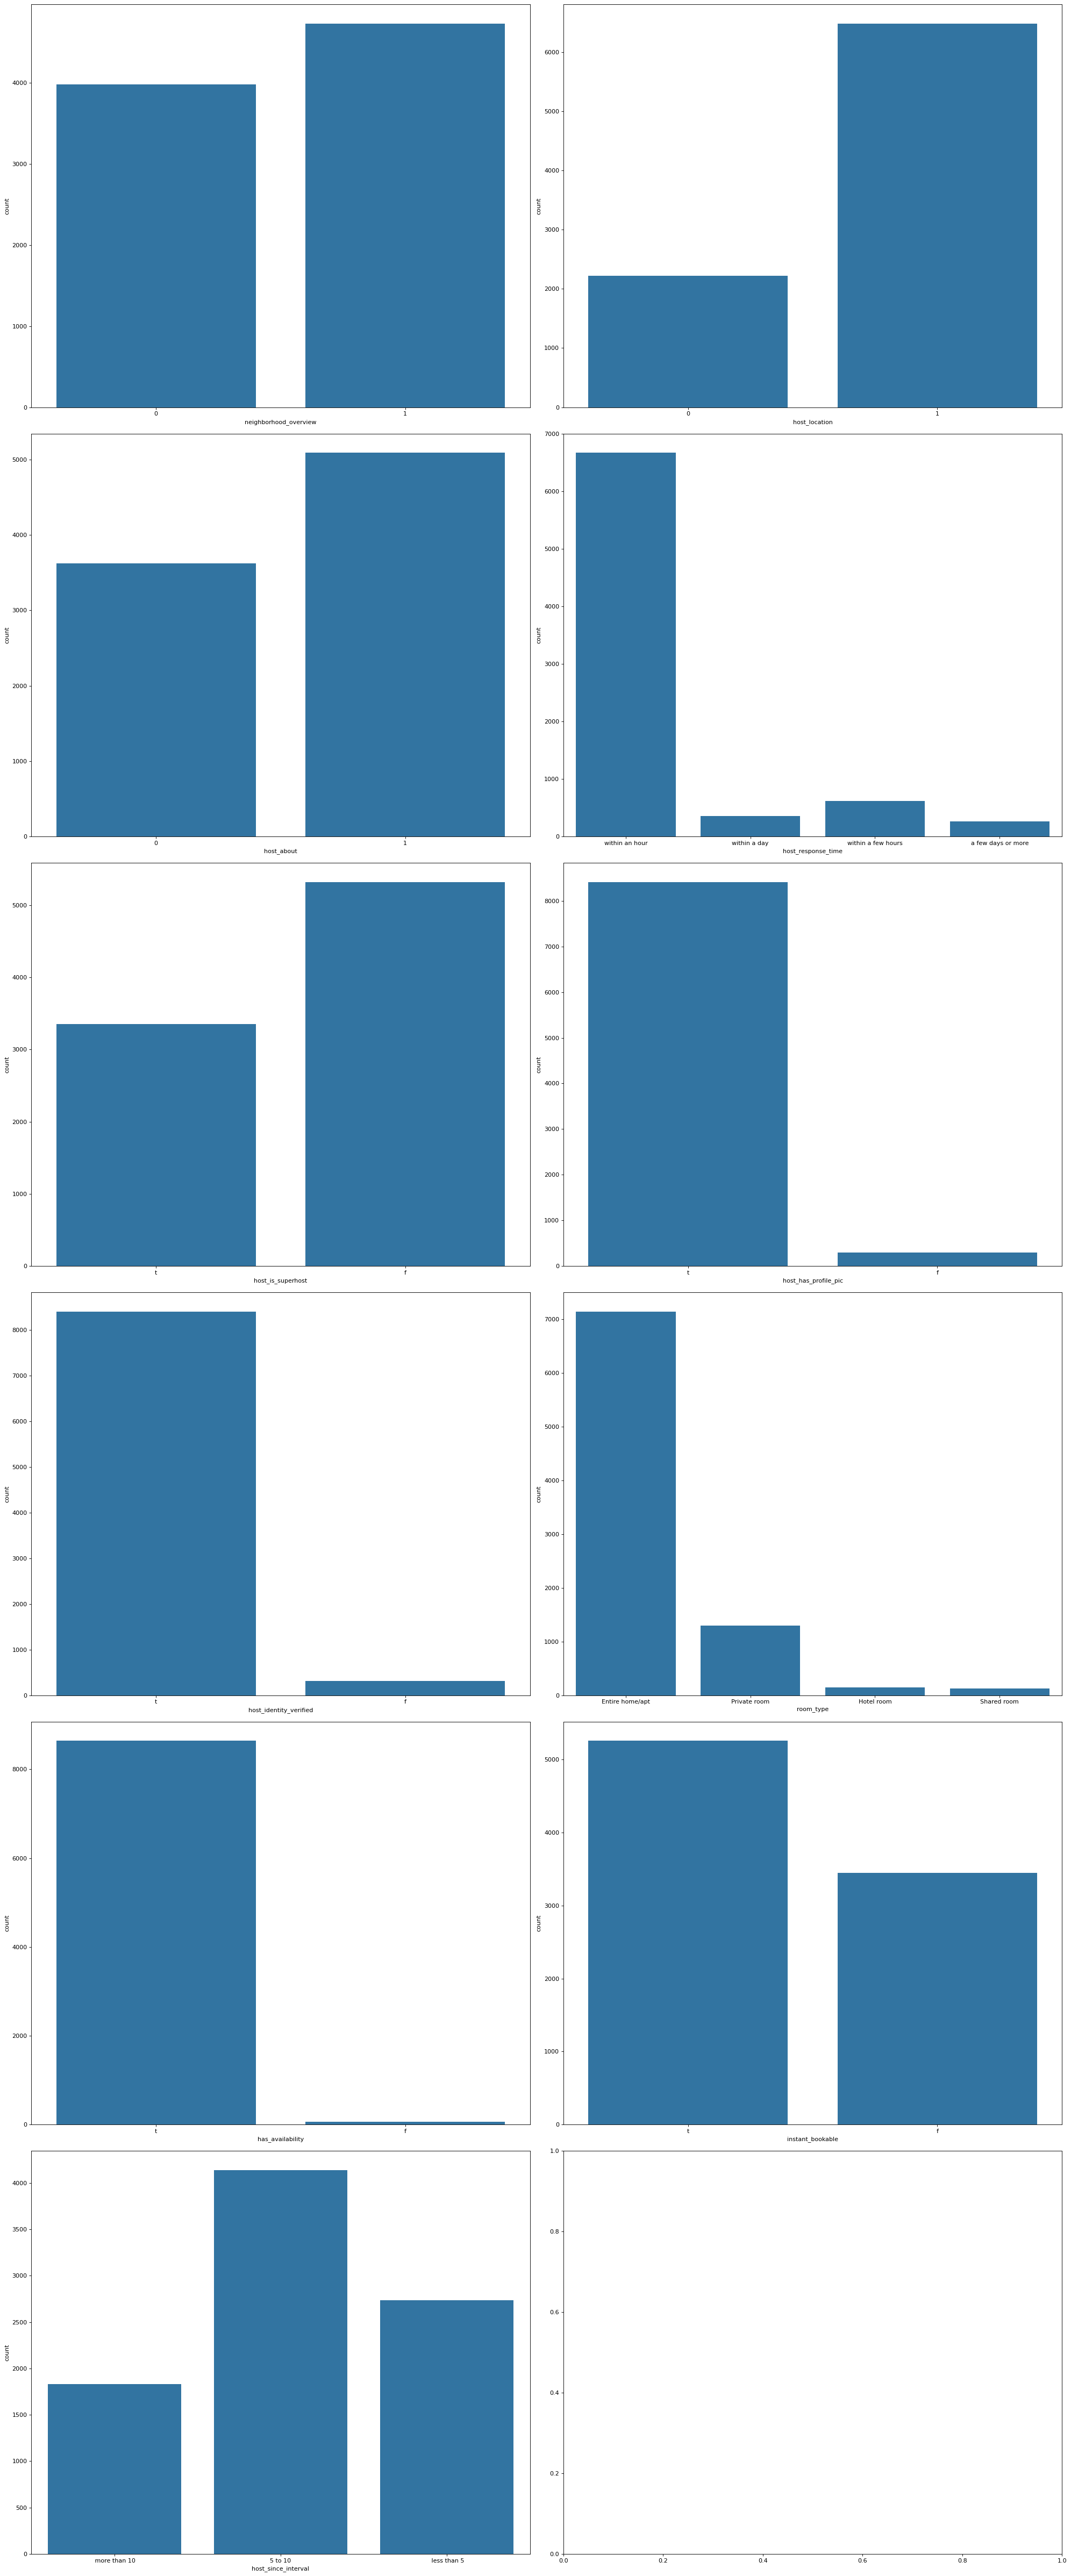

In [44]:
# Figuring number of unique values - just to ensure categories within our variables. 
unique_values_count = data_prague_price.nunique()

# Review_scores_rating graph
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(data_prague_price["review_scores_rating"])
plt.show()

# Column graphs use to visualize categorical variables
fig, axs = plt.subplots(6, 2, figsize=(25, 60), dpi=80)

sns.countplot(data=data_prague_price, x="neighborhood_overview", ax=axs[0, 0])
sns.countplot(data=data_prague_price, x="host_location", ax=axs[0, 1])
sns.countplot(data=data_prague_price, x="host_about", ax=axs[1, 0])
sns.countplot(data=data_prague_price, x="host_response_time", ax=axs[1, 1])
sns.countplot(data=data_prague_price, x="host_is_superhost", ax=axs[2, 0])
sns.countplot(data=data_prague_price, x="host_has_profile_pic", ax=axs[2, 1])
sns.countplot(data=data_prague_price, x="host_identity_verified", ax=axs[3, 0])
sns.countplot(data=data_prague_price, x="room_type", ax=axs[3, 1])
sns.countplot(data=data_prague_price, x="has_availability", ax=axs[4, 0])
sns.countplot(data=data_prague_price, x="instant_bookable", ax=axs[4, 1])
sns.countplot(data=data_prague_price, x="host_since_interval", ax=axs[5, 0])

plt.tight_layout()
plt.show()

#will be described after all the necessary changes 

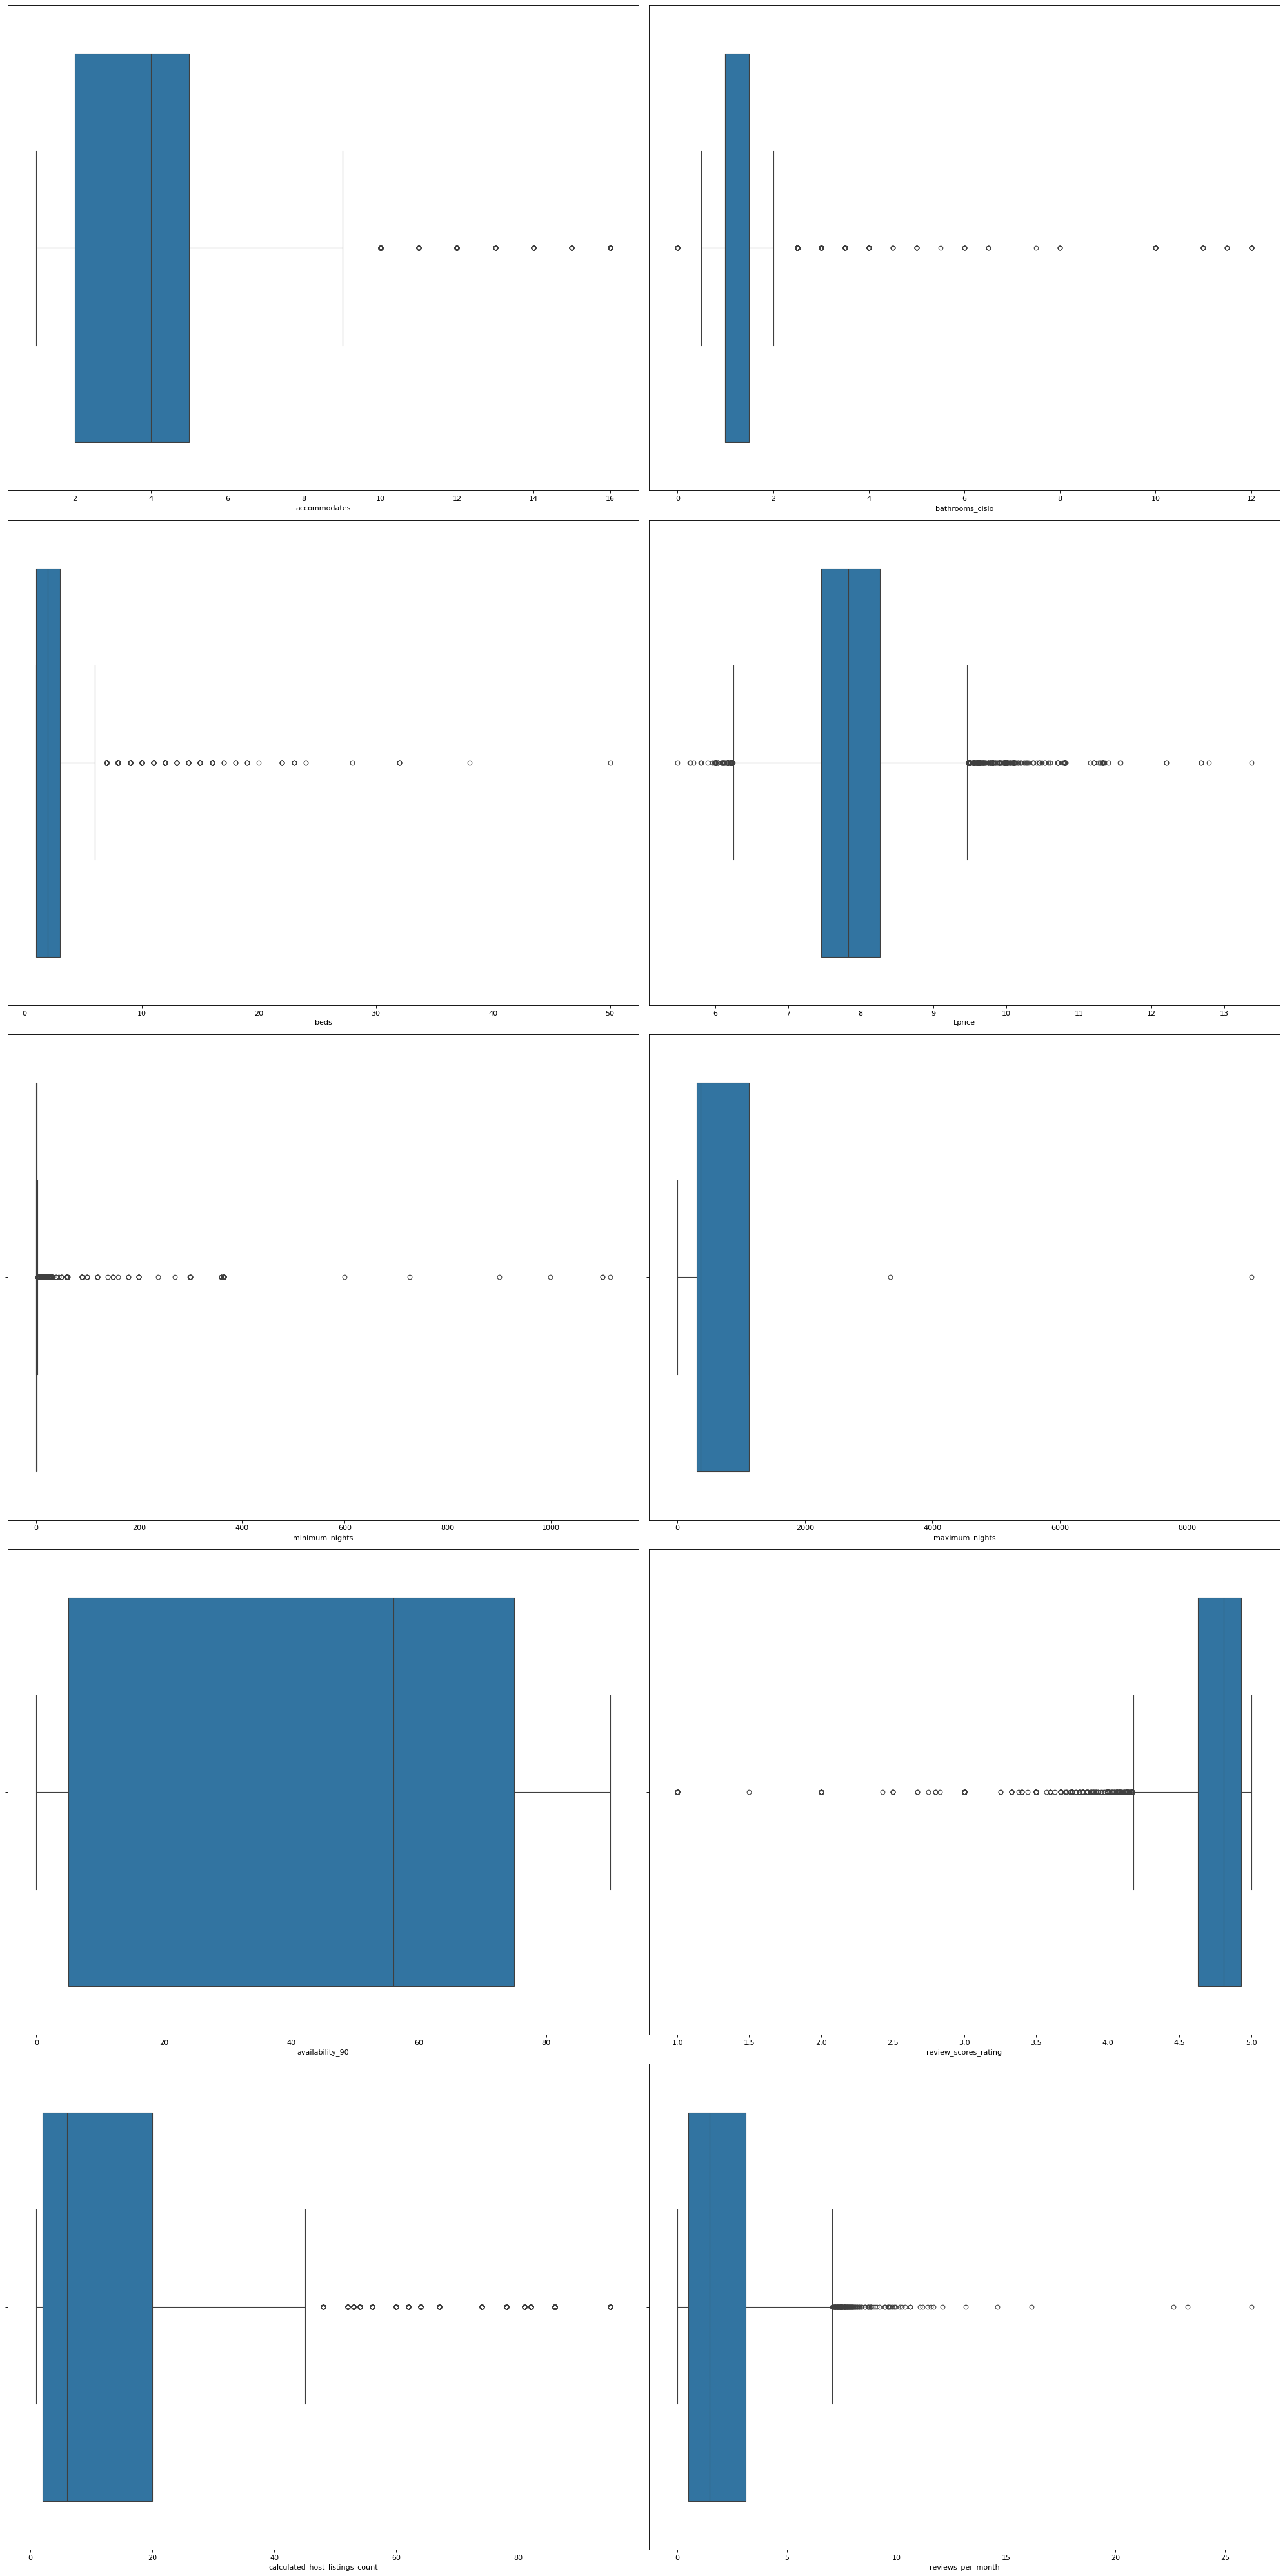

In [45]:
# Boxplots use to visualize numerical variables 
fig, axs = plt.subplots(5, 2, figsize=(25, 50), dpi=80)

sns.boxplot(data=data_prague_price, x="accommodates", ax=axs[0, 0])
sns.boxplot(data=data_prague_price, x="bathrooms_cislo", ax=axs[0, 1])
sns.boxplot(data=data_prague_price, x="beds", ax=axs[1, 0])
sns.boxplot(data=data_prague_price, x="Lprice", ax=axs[1, 1])
sns.boxplot(data=data_prague_price, x="minimum_nights", ax=axs[2, 0])
sns.boxplot(data=data_prague_price, x="maximum_nights", ax=axs[2, 1])
sns.boxplot(data=data_prague_price, x="availability_90", ax=axs[3, 0])
sns.boxplot(data=data_prague_price, x="review_scores_rating", ax=axs[3, 1])
sns.boxplot(data=data_prague_price, x="calculated_host_listings_count", ax=axs[4, 0])
sns.boxplot(data=data_prague_price, x="reviews_per_month", ax=axs[4, 1])

plt.tight_layout()
plt.show()

#will be described after all the necessary changes 


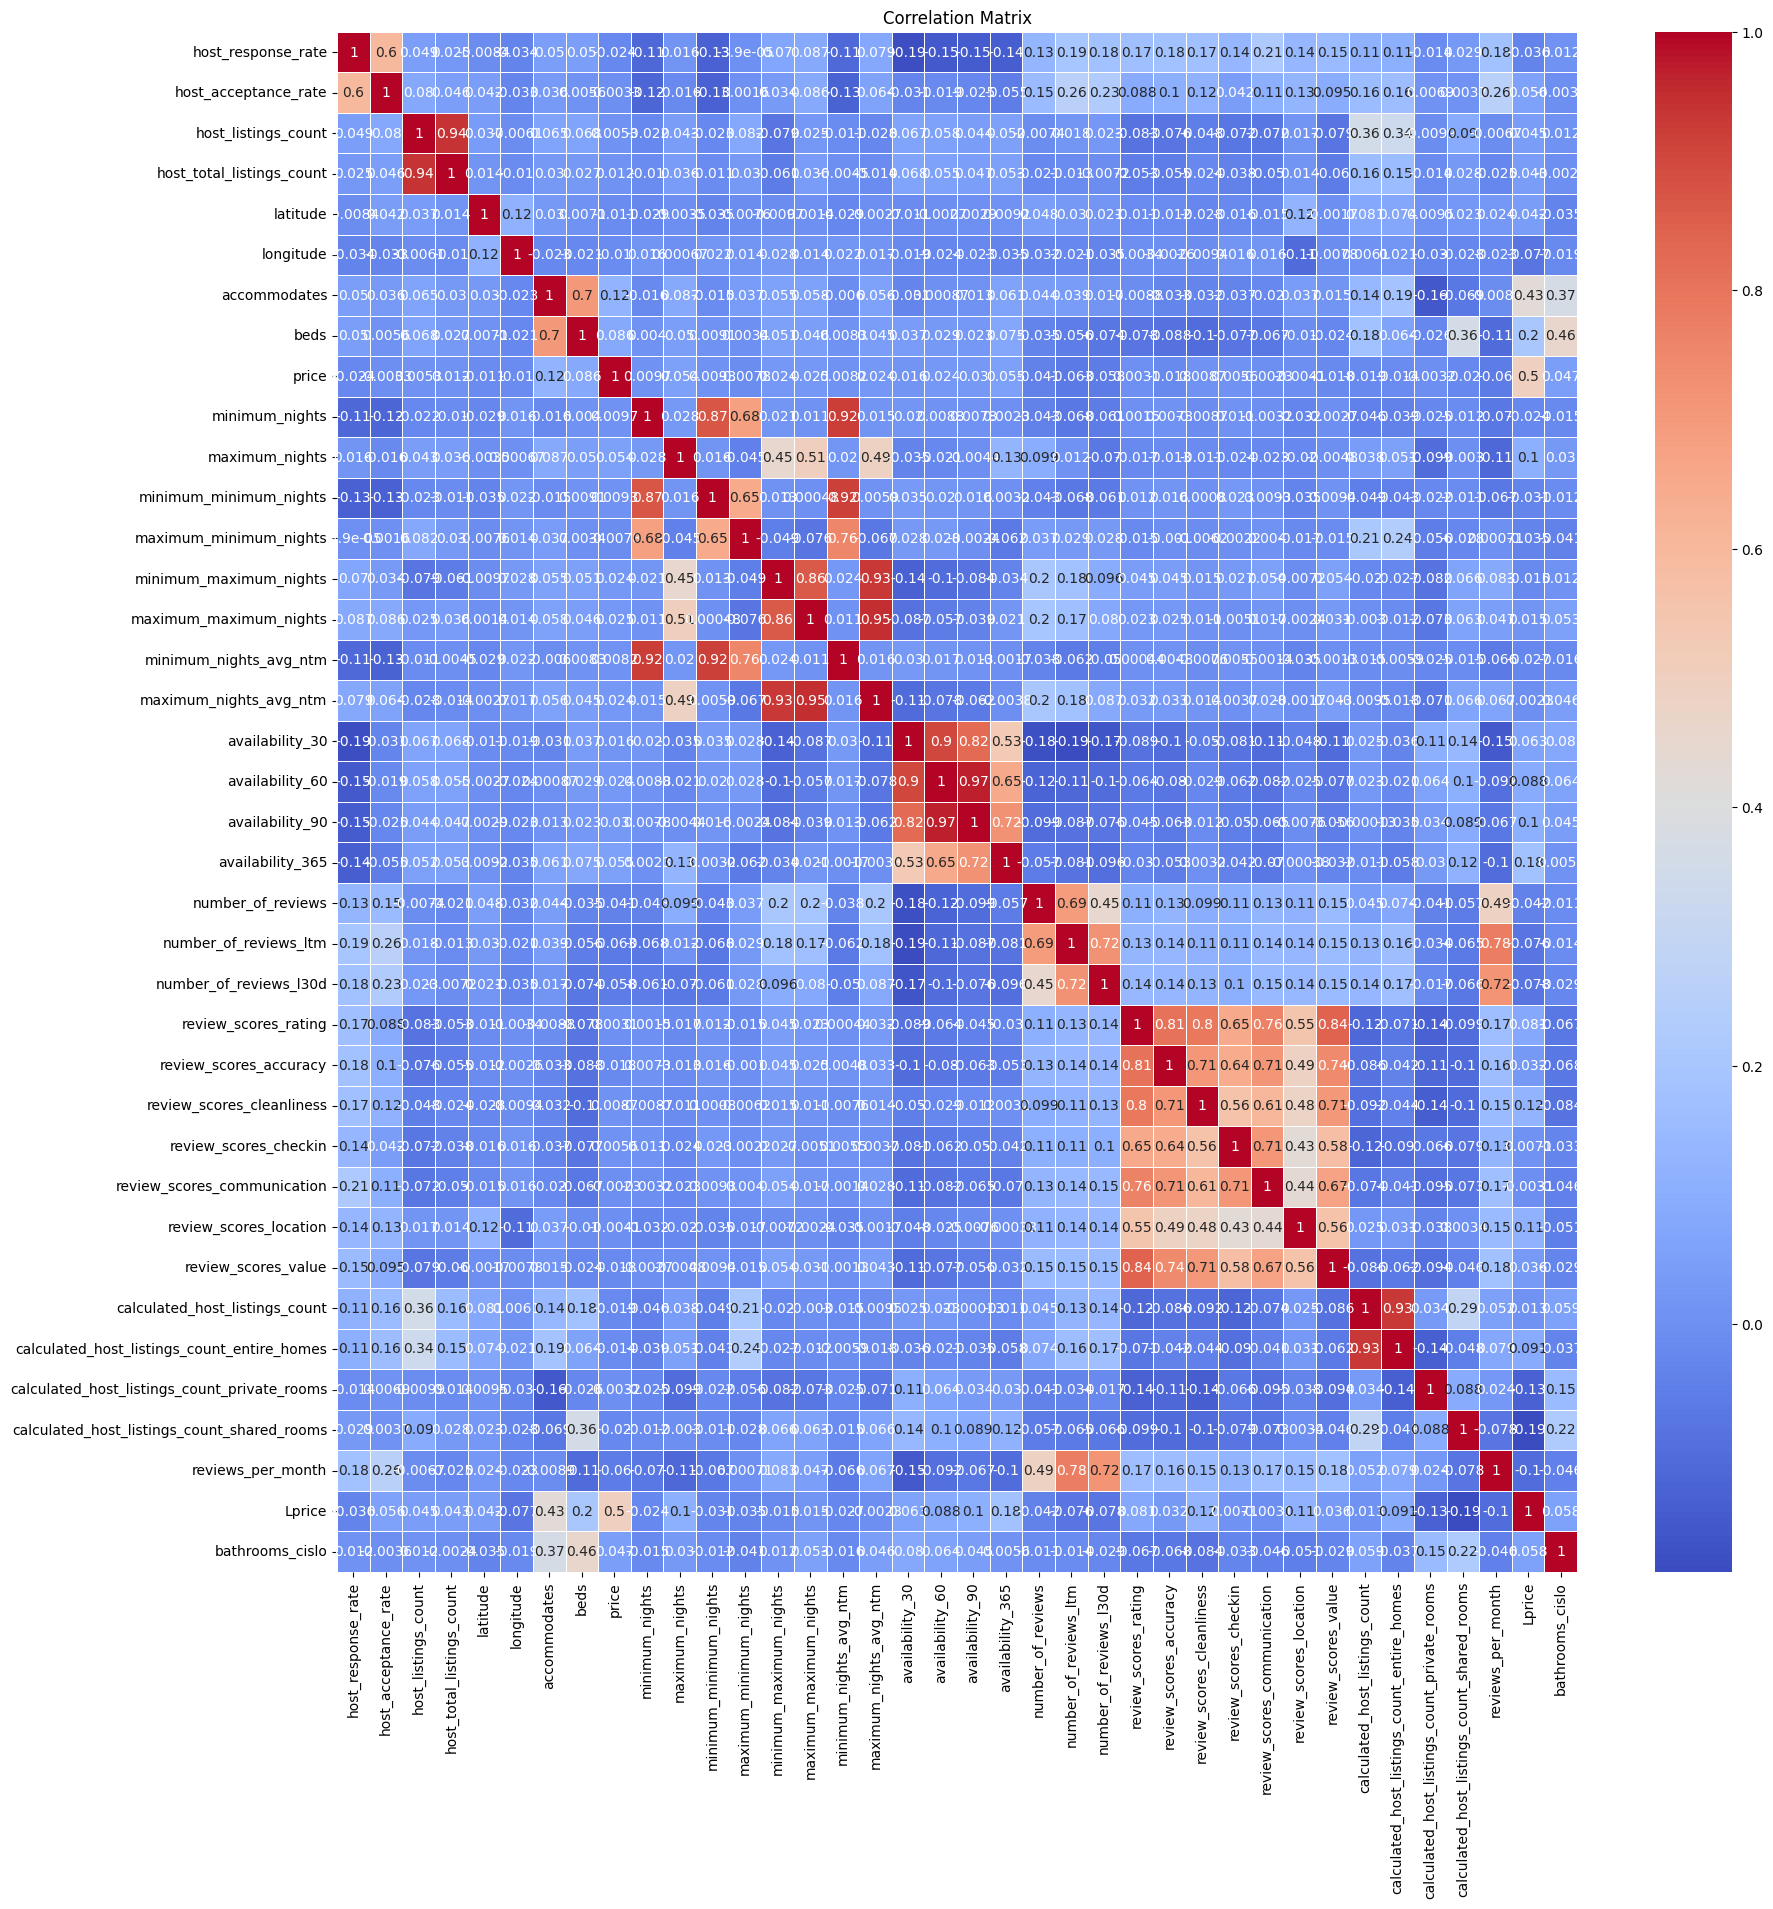

In [46]:
#Summary statistics
summary_stat = data_prague_price.describe(include='all')
summary_stat.transpose

# Dealing with missing values and more categorical variables. 
# Number of unique values
unique_values_count = data_prague_price.nunique()
# Number of missing values
isna_price = data_prague_price.isna().sum()
# Creating DataFrame
summary_df = pd.DataFrame({
    'Unique_Values_Count': unique_values_count,
    'Isna_Count': isna_price
})

data_prague_price = pd.get_dummies(data_prague_price, columns=["host_response_time"], drop_first=True)
data_prague_price = pd.get_dummies(data_prague_price, columns=["neighborhood_overview",
                                                               "host_location",
                                                               "host_about",
                                                               "host_is_superhost",
                                                               "host_has_profile_pic",
                                                               "host_identity_verified",
                                                               "has_availability",
                                                               "instant_bookable"], drop_first=True)

# Numeric variables excluding id and host_id
numeric_columns = data_prague_price.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns.drop(['id', 'host_id'])
correlation_matrix = data_prague_price[numeric_columns].corr()

# Visualization of correlation matrix of all numerical variables. 
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In the correlation matrix, we display dependencies among individual variables that we retain in the model.

We observe that the explained variable Lprice exhibits a stronger dependency with the variable accommodates. Therefore, we expect this variable to have an impact on price development.

The variable accommodates also shows a dependency with the variable beds. This can be expected, considering that the variable reflects the possible number of guests.

Furthermore, we observe a relatively strong positive dependency between the variables host_acceptance_rate and host_response_rate.


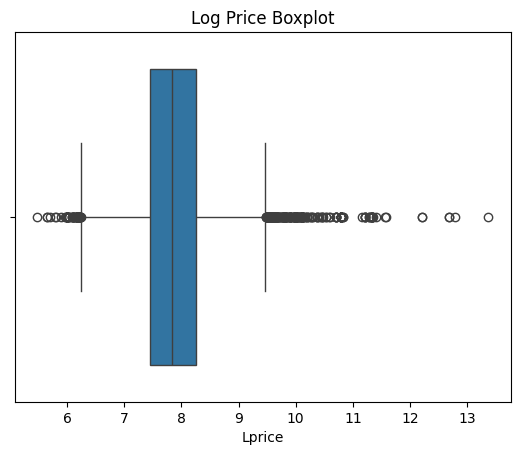

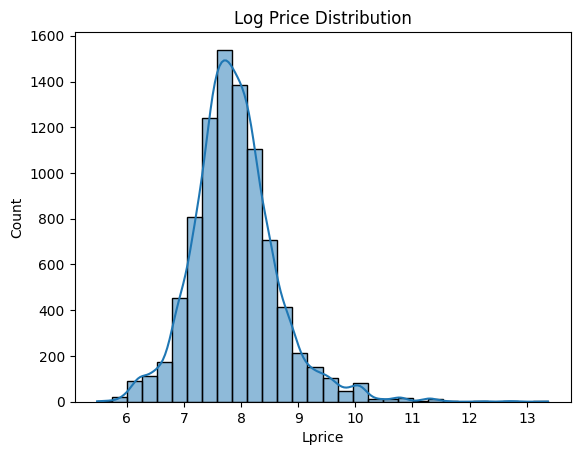

In [47]:
# Boxplot to check for outliers in the 'Lprice' column
sns.boxplot(x=data_prague_price['Lprice'])
plt.title('Log Price Boxplot')
plt.show()

# Histogram to understand the distribution of 'Lprice'
sns.histplot(data_prague_price['Lprice'], bins=30, kde=True)
plt.title('Log Price Distribution')
plt.show()

#### Price on the map

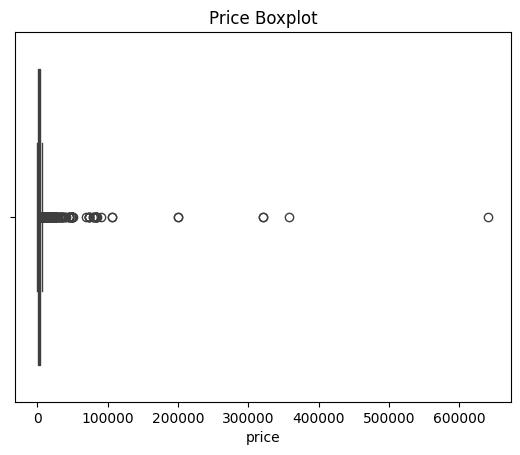

count      8708.000000
mean       3979.619775
std       11156.265693
min         240.000000
25%        1727.000000
50%        2511.000000
75%        3864.000000
max      641055.000000
Name: price, dtype: float64

In [48]:
sns.boxplot(x=data_prague_price['price'])
plt.title('Price Boxplot')
plt.show()

data_prague_price["price"].describe()

In [49]:
# Create price categories
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, data_prague_price['price'].max()]
labels = ['<500', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500-3000', '3000-3500', '3500-4000', '4000-4500', '4500-5000', '>5000']
data_prague_price['price_range'] = pd.cut(data_prague_price['price'], bins=bins, labels=labels, include_lowest=True)

# Assign a discrete color for each price range
color_discrete_map = {label: color for label, color in zip(labels, px.colors.qualitative.Set1)}

# Create Graph
fig = px.scatter_mapbox(data_prague_price, lat="latitude", lon="longitude",
                        color="price_range",  # Use price range for color
                        color_discrete_map=color_discrete_map,  # Use the color map
                        size_max=15,
                        zoom=10,
                        mapbox_style="open-street-map",
                        title="Airbnb Listings in Prague",
                        category_orders={"price_range": labels})  # Ensure legend order

# Improve layout
fig.update_layout(
    margin={"r": 0, "t": 40, "l": 0, "b": 0},
    legend_title_text='Price Range'
)

For the maps, we improved the intervals by adding more categories. We used common sense for making the intervals between categories, as 500 CZK per night is quite a difference. We also added a map where you can filter listings via their price category.

In [51]:

app = dash.Dash(__name__)
 
# Buttons
price_range_options = [{'label': label, 'value': label} for label in labels]
price_range_selector = dcc.Dropdown(
    id='price-range-selector',
    options=price_range_options,
    value=labels[0],  # Nastavení výchozí hodnoty
    clearable=False
)
 
# Callback for updating the graph based on the selected price range
@app.callback(
    Output('prague-listings-map', 'figure'),
    [Input('price-range-selector', 'value')]
)
def update_map(price_range):
    filtered_data = data_prague_price[data_prague_price['price_range'] == price_range]
    fig = px.scatter_mapbox(filtered_data, lat="latitude", lon="longitude",
                            color="price_range",
                            color_discrete_map=color_discrete_map,
                            size_max=15,
                            zoom=10,
                            mapbox_style="open-street-map",
                            title="Airbnb Listings in Prague - Price Range: {}".format(price_range))
    fig.update_layout(
        margin={"r": 0, "t": 40, "l": 0, "b": 0},
        legend_title_text='Price Range'
    )
    return fig
 
# Layout of the application
app.layout = html.Div([
    html.H1("Airbnb Listings in Prague"),
    html.Div([
        html.Label("Select Price Range:"),
        price_range_selector
    ]),
    dcc.Graph(id='prague-listings-map')
])
 
# Run the application on port 8051
if __name__ == '__main__':
    app.run_server(port=8051)

Our explained variable is the Price variable, expressed in CZK per night. 

We can see that the majority of accommodations exceed the threshold of 2000 CZK per night. 

This is definitely influenced by the popularity of the location and the desire to stay in the desired center.


#### Handling missing values and outliers
we used method of interpolation, which is based on 
estimation of missing values based on surrounding values in the given column. 

The 'linear' method denotes linear interpolation, which creates linear connections 
between two neighboring known points and uses them to estimate the missing value.

host_response_rate                              792
host_acceptance_rate                            530
host_listings_count                               0
host_total_listings_count                         0
latitude                                          0
longitude                                         0
accommodates                                      0
beds                                            147
price                                             0
minimum_nights                                    0
maximum_nights                                    0
minimum_minimum_nights                            1
maximum_minimum_nights                            1
minimum_maximum_nights                            1
maximum_maximum_nights                            1
minimum_nights_avg_ntm                            1
maximum_nights_avg_ntm                            1
availability_30                                   0
availability_60                                   0
availability

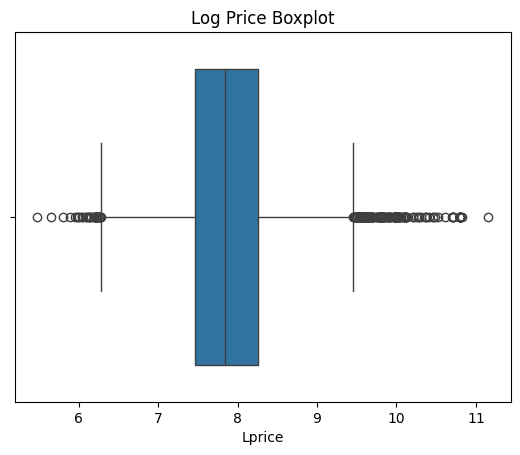

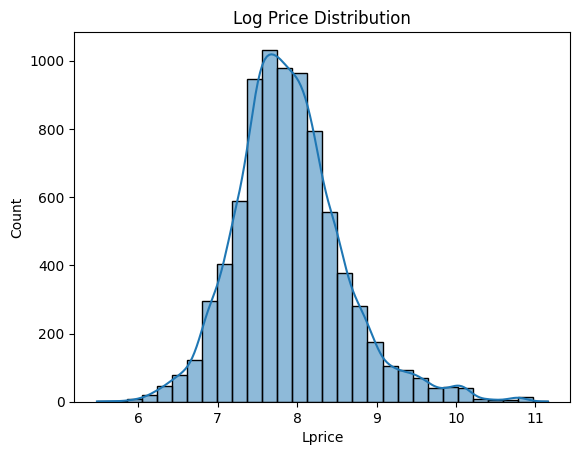

<class 'pandas.core.frame.DataFrame'>
Index: 8708 entries, 0 to 9387
Data columns (total 64 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            8708 non-null   int64         
 1   name                                          8708 non-null   object        
 2   host_id                                       8708 non-null   int64         
 3   host_since                                    8708 non-null   datetime64[ns]
 4   host_response_rate                            8708 non-null   float64       
 5   host_acceptance_rate                          8708 non-null   float64       
 6   host_listings_count                           8708 non-null   int64         
 7   host_total_listings_count                     8708 non-null   int64         
 8   neighbourhood_cleansed                        8708 non-null   object     

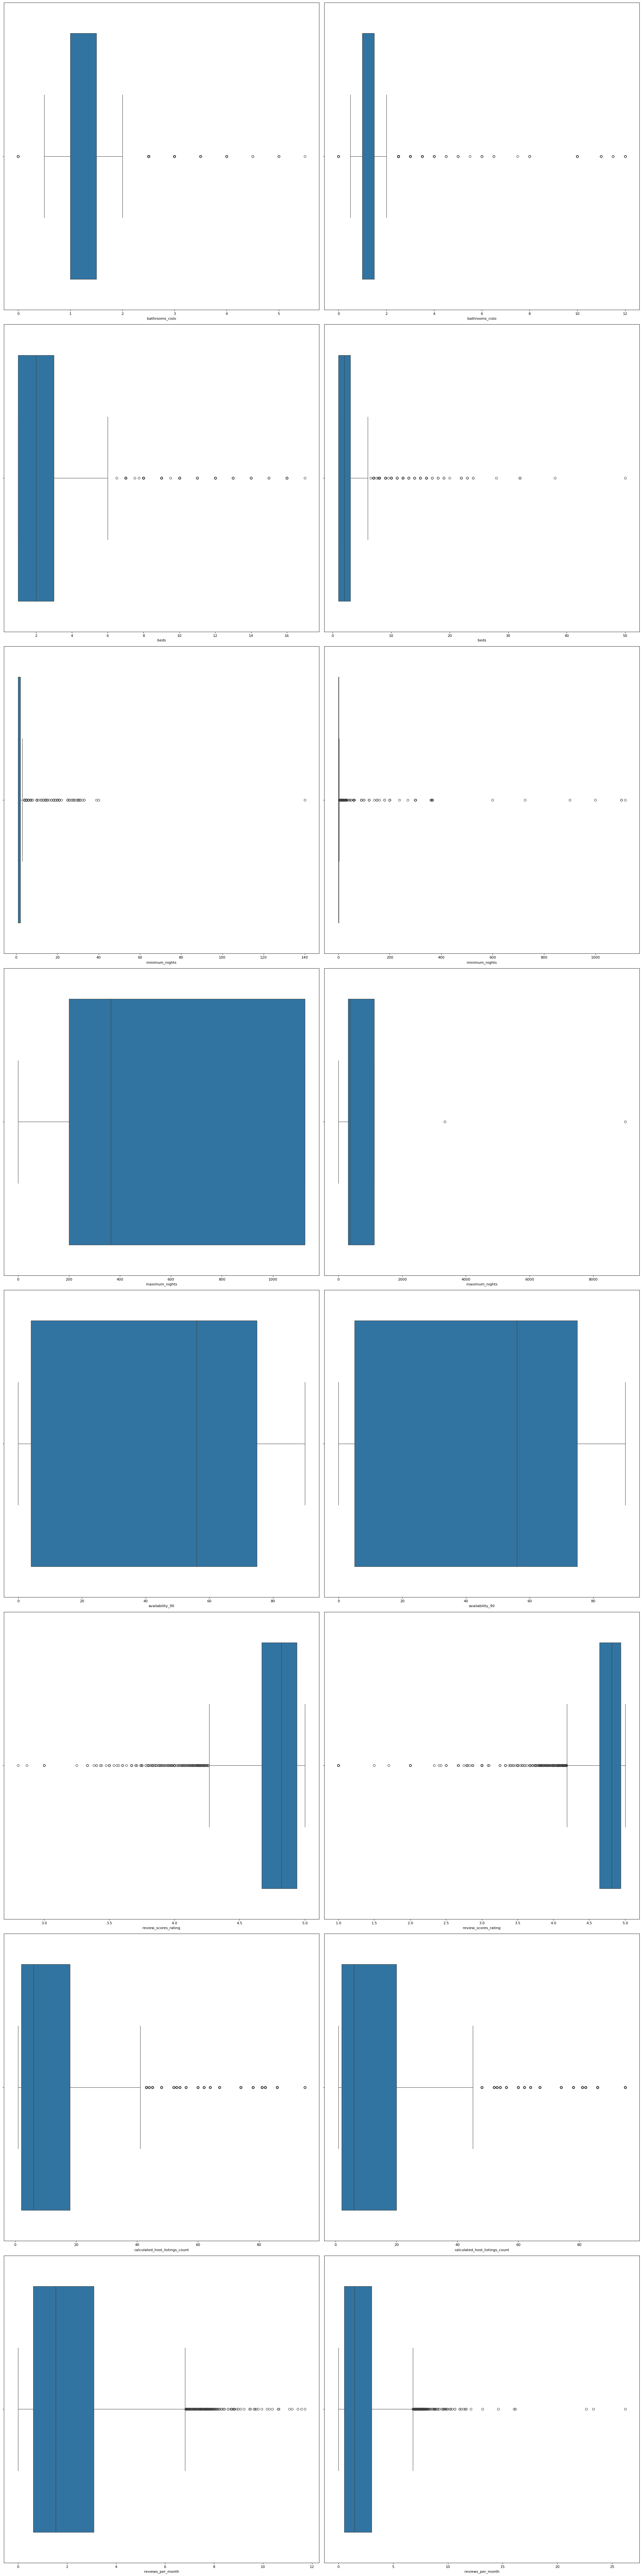

In [14]:
print(data_prague_price[numeric_columns].isna().sum())
#Replacing missing values by interpolation method 
data_prague_price[numeric_columns] = data_prague_price[numeric_columns].interpolate(method='linear')

# Defining a function to remove outliers based on standard deviation. 
#this code removes all observation that lies furher than 6times there standart deviation from mean. 
#Because we included more variables than before, we had to take 6times of std deviation instead of 3,
#otherwise we would have half the data as before.
def remove_outliers(df, threshold=6):
    df_cleaned = df.copy()  # Creating a copy of the DataFrame
    for column in df_cleaned.select_dtypes(include=['number']):  # Selecting only numeric columns
        mean = df_cleaned[column].mean()
        std_dev = df_cleaned[column].std()
        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    return df_cleaned

# Calling the function to remove outliers
df_cleaned = remove_outliers(data_prague_price)
df_cleaned.info()

# Boxplot to check for outliers in the 'Lprice' column after. 
sns.boxplot(x=df_cleaned['Lprice'])
plt.title('Log Price Boxplot')
plt.show()

# Histogram to understand the distribution of 'Lprice' - see any changes after outlier puf 
sns.histplot(df_cleaned['Lprice'], bins=30, kde=True)
plt.title('Log Price Distribution')
plt.show()

# Comparison of record counts
data_prague_price.info()
df_cleaned.info()

# Creating subplots
fig, axs = plt.subplots(8, 2, figsize=(25, 100), dpi=80)

# Displaying boxplot of some of the variables after all necesary changes in dataset with and withour outliners. 
sns.boxplot(data=df_cleaned, x="bathrooms_cislo", ax=axs[0, 0])
sns.boxplot(data=data_prague_price, x="bathrooms_cislo", ax=axs[0, 1])

sns.boxplot(data=df_cleaned, x="beds", ax=axs[1, 0])
sns.boxplot(data=data_prague_price, x="beds", ax=axs[1, 1])

sns.boxplot(data=df_cleaned, x="minimum_nights", ax=axs[2, 0])
sns.boxplot(data=data_prague_price, x="minimum_nights", ax=axs[2, 1])

sns.boxplot(data=df_cleaned, x="maximum_nights", ax=axs[3, 0])
sns.boxplot(data=data_prague_price, x="maximum_nights", ax=axs[3, 1])

sns.boxplot(data=df_cleaned, x="availability_90", ax=axs[4, 0])
sns.boxplot(data=data_prague_price, x="availability_90", ax=axs[4, 1])

sns.boxplot(data=df_cleaned, x="review_scores_rating", ax=axs[5, 0])
sns.boxplot(data=data_prague_price, x="review_scores_rating", ax=axs[5, 1])

sns.boxplot(data=df_cleaned, x="calculated_host_listings_count", ax=axs[6, 0])
sns.boxplot(data=data_prague_price, x="calculated_host_listings_count", ax=axs[6, 1])

sns.boxplot(data=df_cleaned, x="reviews_per_month", ax=axs[7, 0])
sns.boxplot(data=data_prague_price, x="reviews_per_month", ax=axs[7, 1])

plt.tight_layout()
plt.show()

In this graph, variables included in the following models were displayed before and after outlier and NA value adjustments. These adjustments notably affected variables such as bathroom_cislo and beds.


In [15]:
#saved data used for further modeling (first try)
df_cleaned.dtypes
df_cleaned.to_csv("data_cleaned.csv")

In [22]:
#XG Boost on dataset with more variables than before, chosen model: the best one 

# Dropping unnecessary columns for the model
df_model=df_cleaned
columns_to_drop2 = ['id', 'host_id','price','name','host_since','host_since_interval','bathrooms_text','Hotel room','Shared room','Private room','price_range']
df_model = df_model.drop(columns_to_drop2, axis=1)
#Setting seed for replicability 
seed = 500

#Mean encoding for variables with a lot of categories
#train test split
x_train, x_test, y_train, y_test= train_test_split(
    df_model.drop(['Lprice'], axis = 1), 
    df_model[['Lprice']], 
    test_size=0.2, 
    random_state=seed
    )

#Categories to encode
categ_names= ['neighbourhood_cleansed', 'property_type','room_type']

for c in categ_names: # for each categorical variable
    encoder = TargetEncoder() # instantiate target encoder
    encoder.fit(x_train[c], y_train) # calculate means of target on training data (=fit the encoder)
    x_train[c+'_mean'] = encoder.transform(x_train[c]) # map the training data means to training data
    x_test[c+'_mean'] = encoder.transform(x_test[c]) # map the training data means to test data
    # drop the original categorical columns
    x_train.drop(c, axis=1, inplace=True)
    x_test.drop(c, axis=1, inplace=True)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters found:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Lowest RMSE found:  0.4124942637358381
0.3996625670500689
0.6437192439077788


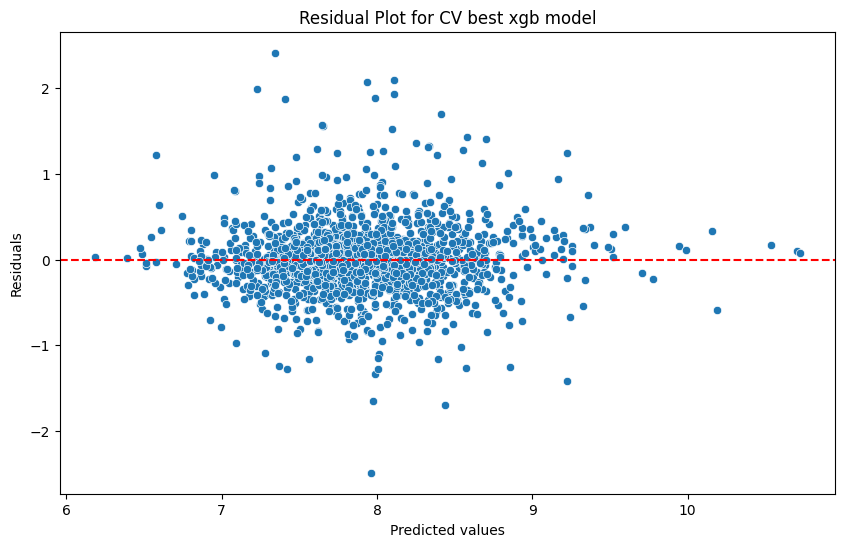

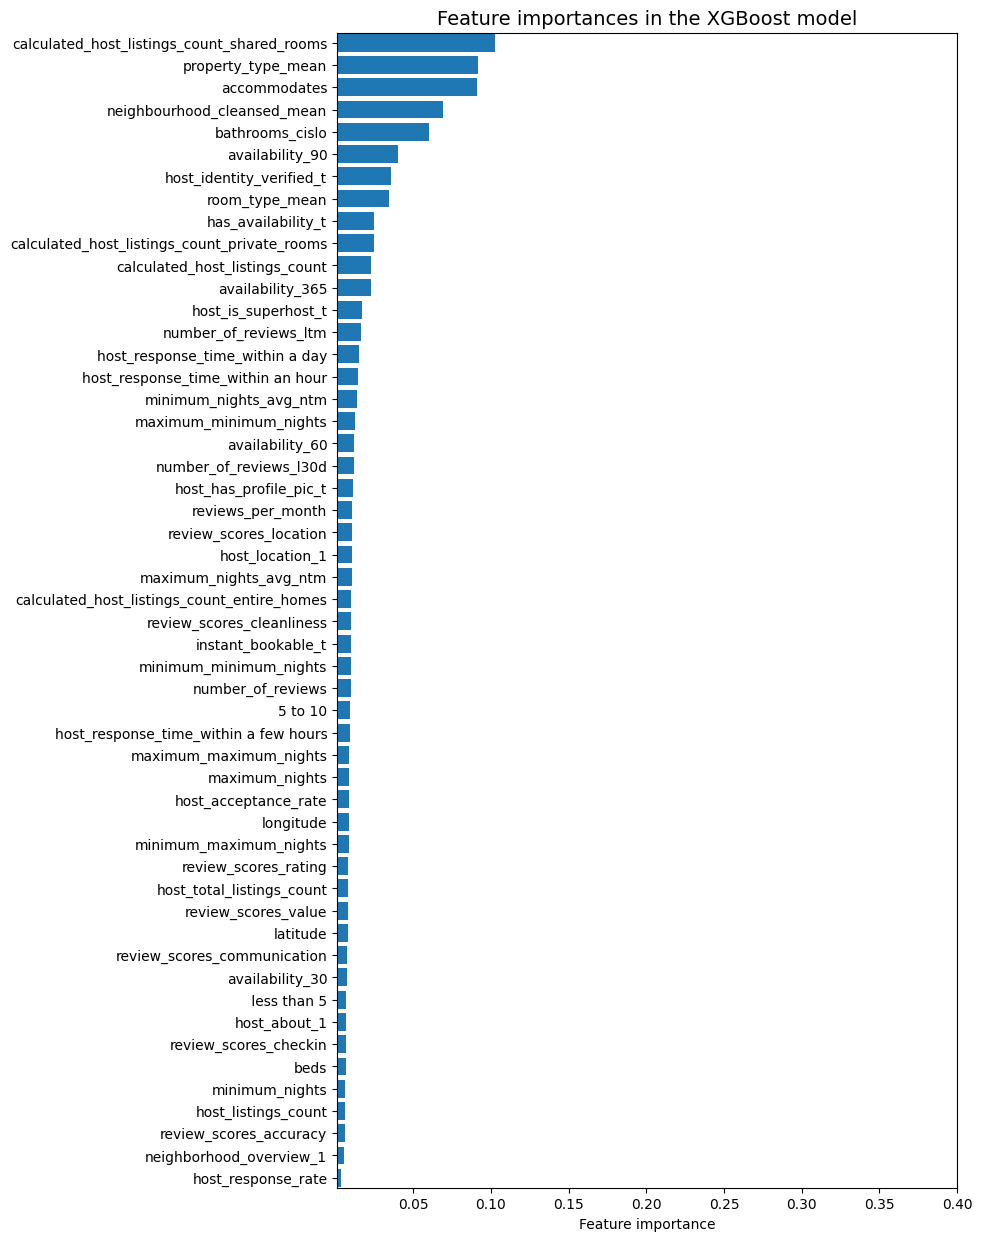

                                               weight
calculated_host_listings_count_shared_rooms  0.102487
property_type_mean                           0.091668
accommodates                                 0.090805
neighbourhood_cleansed_mean                  0.068920
bathrooms_cislo                              0.060394


In [23]:
#setup params grid
param_grid = {'learning_rate': [0.01,0.1,0.5], #alias eta, Step size shrinkage used in update to prevents overfitting.  
    'n_estimators': [20, 50, 100],
    'subsample': [0.5, 0.8, 1], #Subsample ratio of the training instances
    'max_depth': [3, 5, 10],
    'colsample_bytree': [0.5, 1] #colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    }

#Creating an XGBoost model with CV
gbm = xgb.XGBRegressor(seed=seed, objective='reg:squarederror')
xgb_cv = GridSearchCV(estimator=gbm,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1)
#Fitting the model
xgb_cv.fit(x_train, y_train)
#optimise by lowest RMSE

print("Best parameters found: ",xgb_cv.best_params_) #best_params_
print("Lowest RMSE found: ", np.sqrt(np.abs(xgb_cv.best_score_))) #best_score_

#extract the estimator best_estimator_ 
xgb_cv_best = xgb_cv.best_estimator_ #best_estimator_

#Make predictions on the test data
y_pred_xg_best = xgb_cv_best.predict(x_test)

#Evaluate the test set RMSE
rmse_xgb_best = mean_squared_error(y_test, y_pred_xg_best, squared=False)
print(rmse_xgb_best)

#R2 score
r2_xgb_cv_best=r2_score(y_test, y_pred_xg_best)
print(r2_xgb_cv_best)

#Defining the residuals
residuals_5 = y_test.values.ravel() - y_pred_xg_best

#Plotting the predicted values vs residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_xg_best, y=residuals_5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for CV best xgb model')
plt.show()

#which features are the most important?
ft_weights_xgb_cv = pd.DataFrame(xgb_cv_best.feature_importances_, columns=['weight'], index=x_train.columns)
ft_weights_xgb_cv.sort_values('weight', inplace=True)
ft_weights_xgb_cv

# Plotting feature importances
plt.figure(figsize=(8,15))
plt.barh(ft_weights_xgb_cv.index, ft_weights_xgb_cv.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.001)
plt.xlim(0.001, 0.4)
plt.show()

#which features are the most important? Cutoff 0.05
xbg_sorted_cv=ft_weights_xgb_cv.sort_values('weight',ascending=False)
print(xbg_sorted_cv[xbg_sorted_cv['weight'] > 0.05])

We can see that this model chose these variables as most important: calculated_host_listings_count_shared_rooms, property_type_mean, accomodates, neighbourhood_cleansed_mean and bathrooms_cislo.

In [24]:
print(r2_xgb_cv_best)
print(rmse_xgb_best)

0.6437192439077788
0.3996625670500689


We can see that addding more variables did improve the RMSE, but only slightly, as the best model's RMSE from the first try was 0,400069. This new model was able to predict more variance than the models before, but only slightly, as it explained around 64 %, but the previous model was able to explain 55 % of the variance.